In [20]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'


from datetime import datetime, date
import yfinance as yf
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

'''getting stock history obj'''
#tickerSymbol = 'SPY'
#tickerData = yf.Ticker(tickerSymbol)
#tickerDf = tickerData.history( start='2019-1-2', end='2020-5-31')

tickerDf = yf.download(tickers="MSFT", period="720d", interval="1h")




[*********************100%***********************]  1 of 1 completed


In [12]:
### '''getting data from dataframe'''
dateIndexFrame=tickerDf.index

'''turning all values to list'''
valuesList = tickerDf.values

'''getting close values for EMA 200'''
closeList = tickerDf["Close"]
ema200 = closeList.ewm(span=200).mean().tolist()

'''getting only prices (first 4 elements) / volumes (5th) for normaliztion'''
priceList=[]
for idx, el in enumerate(valuesList):
    x = el[0:4].tolist()
    x.append(ema200[idx])     #Adding EMA200
    priceList+=[x]


volumeList = [[row[4]] for row in valuesList]

'''creating manual normalizing functions'''
priceScaler = 0
volumeScaler = 0
def ManualNorm(notnormList, pv):
    global priceScaler, volumeScaler
    outputList = notnormList
    maxValue = 0
    
    for i in notnormList:
        maxTmp = max(i)
        if maxTmp > maxValue:
            maxValue = maxTmp
            
    for lidx, l in enumerate(notnormList):
        for jidx, j in enumerate(l):
            outputList[lidx][jidx] = j/maxValue
            
    if pv == 0:
        priceScaler = maxValue
    elif pv == 1:
        volumeScaler = maxValue
    
    return outputList

def ManualDenorm(normList, pv):
    global priceScaler, volumeScaler
    outputList = normList

    if pv == 0:
        maxValue = priceScaler
    elif pv == 1:
        maxValue = volumeScaler
    
    for lidx, l in enumerate(normList):
        for jidx, j in enumerate(l):
            outputList[lidx][jidx] = j*maxValue
            
    return outputList

'''normalizing with ^ functions'''
priceListNormalized = ManualNorm(priceList,0)        
volumeListNormalized = ManualNorm(volumeList,1)    
    
'''recollecting prices/volume in one list '''
valuesListNormalized = []

'''valuesListNormalized - dataframe normalized'''
for idx, pricesRow in enumerate(priceListNormalized):
    valuesRow = pricesRow
    valuesRow.append(volumeListNormalized[idx][0])
    valuesListNormalized+=[valuesRow]
    

# FIX PRICELIST HAVING VOLUME

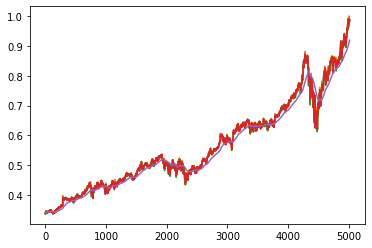

<function matplotlib.pyplot.show(*args, **kw)>

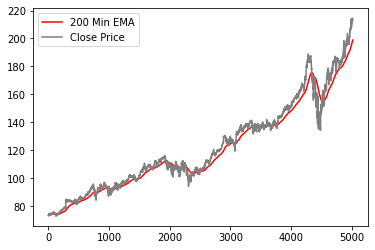

In [13]:
plt.plot([el[0:5] for el in valuesListNormalized])
plt.show()

plt.plot(ema200, label="200 Min EMA", color="red")
plt.plot([row[3] for row in valuesList], label="Close Price", color="grey")
plt.legend(loc='upper left')
plt.show

In [14]:

'''ohlcvValue: Index 0-Open, 1-High, 2-Low, 3-Close, 4-Volume'''
def getDataTarget(ohlcvValue):
    '''predicting based on numDaysForPrediction, predicting average for next numDaysPredicting'''
    numDaysForPrediction = 20
    numDaysPredicting = 5
    step = numDaysForPrediction+numDaysPredicting
    
    '''targetWeek can be used for simulating sell later on'''
    targetWeek = []
    
    forPredictionFullLocal = []
    targetFullLocal = []
        
    for idx in range(0,(len(valuesListNormalized)-(numDaysForPrediction)-(numDaysPredicting)),step):
        #print(idx)
        '''making a list of numDaysForPrediction(20) from valuesListNormalized [1,2,3,..., 20] [2,3,4,...,21] ...'''
        forPredictionSingle = valuesListNormalized[idx:idx+numDaysForPrediction]
        forPredictionFullLocal += [forPredictionSingle]

        '''make a list of targets, average of next numDaysPredicting, for 0-20, getting 20-25'''
        targetRow = valuesListNormalized[idx+numDaysForPrediction:idx+numDaysForPrediction+numDaysPredicting]
        targetTotal = 0
        '''saving target week for later'''
        targetWeek+=[targetRow]
        
        for day in targetRow:
            targetTotal += day[ohlcvValue] # Index 0-Open, 1-High, 2-Low, 3-Close, 4-Volume
        targetFullLocal +=  [targetTotal/numDaysPredicting]

    return forPredictionFullLocal, targetFullLocal, targetWeek




In [15]:
'''to numpy array and splitting to train and test datasets, x_train - y_train, x_test - y_test'''
forPredictionFull, targetFull, targetWeek = getDataTarget(3);

data = np.array(forPredictionFull, dtype=float)
target = np.array(targetFull,dtype=float)
npTargetWeek = np.array(targetWeek,dtype=float)
randState=4

print (data.shape)
print (target.shape)
print (npTargetWeek.shape) 

(200, 20, 6)
(200,)
(200, 5, 6)


In [5]:
'''to numpy array and splitting to train and test datasets, x_train - y_train, x_test - y_test'''
forPredictionFull, targetFull, targetWeek = getDataTarget(3);

data = np.array(forPredictionFull, dtype=float)
target = np.array(targetFull,dtype=float)
npTargetWeek = np.array(targetWeek,dtype=float)
randState=4

print (data.shape)
print (target.shape)
print (npTargetWeek.shape) 

'''Setup model'''
model=Sequential()
'''layers'''
model.add(LSTM((128), batch_input_shape=(None, None, 6),return_sequences=True))

model.add(LSTM((64), batch_input_shape=(None, None, 6),return_sequences=True))

model.add(LSTM((64), batch_input_shape=(None, None, 6),return_sequences=True))

model.add(LSTM((32), batch_input_shape=(None, None, 6),return_sequences=True))

model.add(LSTM((6), batch_input_shape=(None, None, 6)))

model.add(Dense(1))

model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['accuracy'])

(200, 20, 6)
(200,)
(200, 5, 6)


In [16]:
'''training'''
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.1, random_state=randState)

history = model.fit(x_train, y_train, epochs=300, validation_data=(x_test, y_test))

Epoch 1/300
6/6 [==============================] - 0s 77ms/step - loss: 0.0134 - accuracy: 0.0000e+00 - val_loss: 0.0209 - val_accuracy: 0.0000e+00
Epoch 2/300
6/6 [==============================] - 1s 88ms/step - loss: 0.0107 - accuracy: 0.0000e+00 - val_loss: 0.0187 - val_accuracy: 0.0000e+00
Epoch 3/300
6/6 [==============================] - 0s 79ms/step - loss: 0.0094 - accuracy: 0.0000e+00 - val_loss: 0.0151 - val_accuracy: 0.0000e+00
Epoch 4/300
6/6 [==============================] - 0s 78ms/step - loss: 0.0087 - accuracy: 0.0000e+00 - val_loss: 0.0153 - val_accuracy: 0.0000e+00
Epoch 5/300
6/6 [==============================] - 0s 75ms/step - loss: 0.0089 - accuracy: 0.0000e+00 - val_loss: 0.0153 - val_accuracy: 0.0000e+00
Epoch 6/300
6/6 [==============================] - 0s 77ms/step - loss: 0.0089 - accuracy: 0.0000e+00 - val_loss: 0.0155 - val_accuracy: 0.0000e+00
Epoch 7/300
6/6 [==============================] - 0s 75ms/step - loss: 0.0076 - accuracy: 0.0000e+00 - val_loss

6/6 [==============================] - 1s 87ms/step - loss: 0.0078 - accuracy: 0.0000e+00 - val_loss: 0.0139 - val_accuracy: 0.0000e+00
Epoch 57/300
6/6 [==============================] - 1s 87ms/step - loss: 0.0072 - accuracy: 0.0000e+00 - val_loss: 0.0173 - val_accuracy: 0.0000e+00
Epoch 58/300
6/6 [==============================] - 0s 81ms/step - loss: 0.0075 - accuracy: 0.0000e+00 - val_loss: 0.0133 - val_accuracy: 0.0000e+00
Epoch 59/300
6/6 [==============================] - 0s 81ms/step - loss: 0.0078 - accuracy: 0.0000e+00 - val_loss: 0.0135 - val_accuracy: 0.0000e+00
Epoch 60/300
6/6 [==============================] - 1s 94ms/step - loss: 0.0083 - accuracy: 0.0000e+00 - val_loss: 0.0233 - val_accuracy: 0.0000e+00
Epoch 61/300
6/6 [==============================] - 1s 92ms/step - loss: 0.0107 - accuracy: 0.0000e+00 - val_loss: 0.0186 - val_accuracy: 0.0000e+00
Epoch 62/300
6/6 [==============================] - 0s 76ms/step - loss: 0.0087 - accuracy: 0.0000e+00 - val_loss: 0.01

Epoch 111/300
6/6 [==============================] - 1s 94ms/step - loss: 0.0073 - accuracy: 0.0000e+00 - val_loss: 0.0128 - val_accuracy: 0.0000e+00
Epoch 112/300
6/6 [==============================] - 1s 94ms/step - loss: 0.0103 - accuracy: 0.0000e+00 - val_loss: 0.0137 - val_accuracy: 0.0000e+00
Epoch 113/300
6/6 [==============================] - 1s 94ms/step - loss: 0.0091 - accuracy: 0.0000e+00 - val_loss: 0.0142 - val_accuracy: 0.0000e+00
Epoch 114/300
6/6 [==============================] - 1s 86ms/step - loss: 0.0095 - accuracy: 0.0000e+00 - val_loss: 0.0132 - val_accuracy: 0.0000e+00
Epoch 115/300
6/6 [==============================] - 0s 77ms/step - loss: 0.0076 - accuracy: 0.0000e+00 - val_loss: 0.0148 - val_accuracy: 0.0000e+00
Epoch 116/300
6/6 [==============================] - 0s 76ms/step - loss: 0.0080 - accuracy: 0.0000e+00 - val_loss: 0.0129 - val_accuracy: 0.0000e+00
Epoch 117/300
6/6 [==============================] - 0s 73ms/step - loss: 0.0073 - accuracy: 0.0000e

6/6 [==============================] - 0s 74ms/step - loss: 0.0084 - accuracy: 0.0000e+00 - val_loss: 0.0140 - val_accuracy: 0.0000e+00
Epoch 166/300
6/6 [==============================] - 0s 74ms/step - loss: 0.0080 - accuracy: 0.0000e+00 - val_loss: 0.0143 - val_accuracy: 0.0000e+00
Epoch 167/300
6/6 [==============================] - 0s 73ms/step - loss: 0.0067 - accuracy: 0.0000e+00 - val_loss: 0.0148 - val_accuracy: 0.0000e+00
Epoch 168/300
6/6 [==============================] - 0s 72ms/step - loss: 0.0070 - accuracy: 0.0000e+00 - val_loss: 0.0126 - val_accuracy: 0.0000e+00
Epoch 169/300
6/6 [==============================] - 0s 73ms/step - loss: 0.0087 - accuracy: 0.0000e+00 - val_loss: 0.0127 - val_accuracy: 0.0000e+00
Epoch 170/300
6/6 [==============================] - 0s 74ms/step - loss: 0.0069 - accuracy: 0.0000e+00 - val_loss: 0.0163 - val_accuracy: 0.0000e+00
Epoch 171/300
6/6 [==============================] - 0s 73ms/step - loss: 0.0075 - accuracy: 0.0000e+00 - val_loss

6/6 [==============================] - 0s 74ms/step - loss: 0.0072 - accuracy: 0.0000e+00 - val_loss: 0.0130 - val_accuracy: 0.0000e+00
Epoch 220/300
6/6 [==============================] - 0s 72ms/step - loss: 0.0059 - accuracy: 0.0000e+00 - val_loss: 0.0127 - val_accuracy: 0.0000e+00
Epoch 221/300
6/6 [==============================] - 1s 89ms/step - loss: 0.0063 - accuracy: 0.0000e+00 - val_loss: 0.0126 - val_accuracy: 0.0000e+00
Epoch 222/300
6/6 [==============================] - 1s 89ms/step - loss: 0.0061 - accuracy: 0.0000e+00 - val_loss: 0.0115 - val_accuracy: 0.0000e+00
Epoch 223/300
6/6 [==============================] - 0s 79ms/step - loss: 0.0059 - accuracy: 0.0000e+00 - val_loss: 0.0183 - val_accuracy: 0.0000e+00
Epoch 224/300
6/6 [==============================] - 0s 72ms/step - loss: 0.0067 - accuracy: 0.0000e+00 - val_loss: 0.0129 - val_accuracy: 0.0000e+00
Epoch 225/300
6/6 [==============================] - 0s 72ms/step - loss: 0.0066 - accuracy: 0.0000e+00 - val_loss

Epoch 274/300
6/6 [==============================] - 0s 73ms/step - loss: 0.0081 - accuracy: 0.0000e+00 - val_loss: 0.0211 - val_accuracy: 0.0000e+00
Epoch 275/300
6/6 [==============================] - 0s 73ms/step - loss: 0.0109 - accuracy: 0.0000e+00 - val_loss: 0.0204 - val_accuracy: 0.0000e+00
Epoch 276/300
6/6 [==============================] - 0s 73ms/step - loss: 0.0119 - accuracy: 0.0000e+00 - val_loss: 0.0209 - val_accuracy: 0.0000e+00
Epoch 277/300
6/6 [==============================] - 0s 73ms/step - loss: 0.0095 - accuracy: 0.0000e+00 - val_loss: 0.0170 - val_accuracy: 0.0000e+00
Epoch 278/300
6/6 [==============================] - 0s 70ms/step - loss: 0.0084 - accuracy: 0.0000e+00 - val_loss: 0.0122 - val_accuracy: 0.0000e+00
Epoch 279/300
6/6 [==============================] - 0s 71ms/step - loss: 0.0065 - accuracy: 0.0000e+00 - val_loss: 0.0122 - val_accuracy: 0.0000e+00
Epoch 280/300
6/6 [==============================] - 0s 75ms/step - loss: 0.0070 - accuracy: 0.0000e

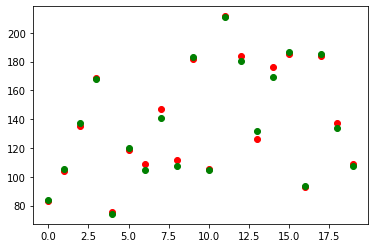

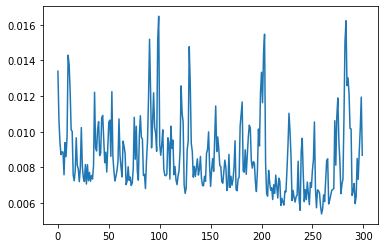

In [17]:
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.1, random_state=randState)


'''testing / predicitng'''
predictionNormalized = model.predict(x_test)

# '''reshaping to 5 items in row, filling with 0s '''
# predictionReshaped = [[row.tolist()[0],0,0,0] for row in predictionNormalized]
# targetReshaped = [[row.tolist(),0,0,0] for row in y_test]

# '''inversing trasnform for prediciton'''
# predictionInversed = priceScaler.inverse_transform(predictionReshaped)
# predictionInversed = [[firstElement[0]] for firstElement in predictionInversed]

'''manual prediction inverse'''
predictionInversed = ManualDenorm(predictionNormalized,0)

# '''inversing trasnform for target'''
# targetInversed = priceScaler.inverse_transform(targetReshaped)
# targetInversed = [[firstElement[0]] for firstElement in targetInversed]

'''manual target inverse'''
targetInversed = ManualDenorm([[el] for el in y_test],0)

'''prediciton / target scatter'''
plt.scatter(range(len(predictionInversed)), predictionInversed , c='r')
plt.scatter(range(len(targetInversed)), targetInversed, c='g')
plt.show()

'''loss graph'''
plt.plot(history.history['loss'])
plt.show()

In [18]:

x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.1, random_state=randState)
xTrainSim, xTestSim, yTrainSim, yTestSim = train_test_split(targetWeek, target, test_size=0.1, random_state=randState)

def tradeSimulation(predOnWeek, targetWeek):
    '''getting close list to simulate buying on close the day before prediction week'''
    x_testPrices = [row[-1][0:4] for row in predOnWeek] #get last day before prediciton week, and strip volume from list
    #x_testInversed = priceScaler.inverse_transform(x_testPrices) #inverse normalization
    x_testInversed = ManualDenorm(x_testPrices,0) #inverse normalization
    x_testOnlyClose = [round(row[3],2) for row in x_testInversed] #get Close price of the day

    tooHighNum = 0
    tooLowNum = 0
    goodGuessNum = 0
    balanceTotal = 0
    balancePercTotal = 0
    
    realBalanceTotal = 0
    realBalancePercTotal = 0
    
    numTrades=0
    passiveTotal = 0
    
    for idx in range(len(x_testOnlyClose)):

        lastWeekClose = x_testOnlyClose[idx]
        weekPredictionAvg = round(predictionInversed[idx][0],2)
        weekActualAvg = round(targetInversed[idx][0],2)

        if weekPredictionAvg < weekActualAvg: tooLowNum+=1
        elif weekPredictionAvg > weekActualAvg: tooHighNum+=1
        else: goodGuessNum+=1
    
        '''calculating balance without ai interference'''   
        tradeTotal = round(weekActualAvg - lastWeekClose,2)
    
        targetWeekPrices = [day[0:4]for day in targetWeek[idx]]
        targetWeekPricesInversed = ManualDenorm(targetWeekPrices,0)
        closeWeekPrice = targetWeekPricesInversed[-1][3]
        passiveTotal+= round(closeWeekPrice - lastWeekClose,2)
        print("\n\nLast Week Closed at ", lastWeekClose, "\t Week Closing at ",round(closeWeekPrice,2),"\t Passive Trade: ", round(passiveTotal,2))
        
        '''only buying those bot liked'''
        if lastWeekClose < weekPredictionAvg: #if next week looks good, we buy a stock and sell on predicted price (tradeTotal)
            '''selling on next week average price (we don't know it)'''
            numTrades+=1

            tradePercTotal = round((tradeTotal/lastWeekClose*100),2)
            balanceTotal+=tradeTotal
            balancePercTotal+=tradePercTotal

            print("Avg Prediction: ", weekPredictionAvg, "    \tAvg Actual: ", weekActualAvg, "\tTrade Total: ", tradeTotal,"$\t", tradePercTotal,"%")

            
            '''selling on predicted price if reached, if not selling on week close'''
            
            gotPredicted=False;

            for num, day in enumerate(targetWeekPricesInversed):  
                maxDayPrice = day[1]
                print("Day", num+1,"Price: ",round(maxDayPrice,2))
                if maxDayPrice > weekPredictionAvg:
                    print("Prediction reached. Selling at: ", weekPredictionAvg)
                    realTradeTotal = round(weekPredictionAvg - lastWeekClose,2)
                    gotPredicted=True
                    break;
            if not gotPredicted:
                closeWeekPrice = targetWeekPricesInversed[-1][3]
                print("Prediction not reached. Selling at: ", closeWeekPrice)
                realTradeTotal = round(closeWeekPrice - lastWeekClose,2)
         
            realTradePercTotal = round((realTradeTotal/lastWeekClose*100),2)
            realBalanceTotal+=realTradeTotal
            realBalancePercTotal+=realTradePercTotal

            print("Real Trade Total: ", realTradeTotal,"$\t", realTradePercTotal,"%")


    if (numTrades==0):
        numTrades=-1

    print("\nTrades Made: ", numTrades)
    print("\nPassive Balance Total: \t", round(passiveTotal,2),"$")
    print("AI Balance Total: \t", round(balanceTotal,2), "$  \tAvg Trade Perc Change: ",round(balancePercTotal/numTrades,2),"%" )
    print("Real AI Balance Total: \t", round(realBalanceTotal,2), "$  \tAvg Trade Perc Change: ",round(realBalancePercTotal/numTrades,2),"%" )

    print("\ntooHighNum: ", tooHighNum, "\ntooLowNum: ",tooLowNum,"\ngoodGuessNum: ",goodGuessNum)

    
out = tradeSimulation(x_test, xTestSim)





Last Week Closed at  84.26 	 Week Closing at  83.59 	 Passive Trade:  -0.67


Last Week Closed at  105.57 	 Week Closing at  106.51 	 Passive Trade:  0.27


Last Week Closed at  136.57 	 Week Closing at  135.93 	 Passive Trade:  -0.37


Last Week Closed at  168.35 	 Week Closing at  166.13 	 Passive Trade:  -2.59
Avg Prediction:  168.76     	Avg Actual:  167.66 	Trade Total:  -0.69 $	 -0.41 %
Day 1 Price:  170.87
Prediction reached. Selling at:  168.76
Real Trade Total:  0.41 $	 0.24 %


Last Week Closed at  74.14 	 Week Closing at  74.91 	 Passive Trade:  -1.82
Avg Prediction:  75.83     	Avg Actual:  74.21 	Trade Total:  0.07 $	 0.09 %
Day 1 Price:  74.22
Day 2 Price:  74.22
Day 3 Price:  74.03
Day 4 Price:  74.08
Day 5 Price:  74.94
Prediction not reached. Selling at:  74.91000366210938
Real Trade Total:  0.77 $	 1.04 %


Last Week Closed at  119.97 	 Week Closing at  119.88 	 Passive Trade:  -1.91


Last Week Closed at  106.41 	 Week Closing at  103.84 	 Passive Trade:  -4.48
Avg

In [21]:
def PrepareTicker(ticker):
    tickerDf = yf.download(tickers=ticker, period="720d", interval="1h")
    ### '''getting data from dataframe'''
    dateIndexFrame=tickerDf.index

    '''turning all values to list'''
    valuesList = tickerDf.values

    '''getting close values for EMA 200'''
    closeList = tickerDf["Close"]
    ema200 = closeList.ewm(span=200).mean().tolist()

    '''getting only prices (first 4 elements) / volumes (5th) for normaliztion'''
    priceList=[]
    for idx, el in enumerate(valuesList):
        x = el[0:4].tolist()
        x.append(ema200[idx])     #Adding EMA200
        priceList+=[x]

    volumeList = [[row[4]] for row in valuesList]

    '''creating manual normalizing functions'''
    priceScaler = 0
    volumeScaler = 0
    
    '''normalizing with ^ functions'''
    priceListNormalized = ManualNorm(priceList,0)        
    volumeListNormalized = ManualNorm(volumeList,1)    

    '''recollecting prices/volume in one list '''
    valuesListNormalized = []

    '''valuesListNormalized - dataframe normalized'''
    for idx, pricesRow in enumerate(priceListNormalized):
        valuesRow = pricesRow
        valuesRow.append(volumeListNormalized[idx][0])
        valuesListNormalized+=[valuesRow]
    # TODO: FIX PRICELIST HAVING VOLUME
    
    '''to numpy array and splitting to train and test datasets, x_train - y_train, x_test - y_test'''
    forPredictionFull, targetFull, targetWeek = getDataTarget(3);

    data = np.array(forPredictionFull, dtype=float)
    target = np.array(targetFull,dtype=float)
    npTargetWeek = np.array(targetWeek,dtype=float)
    
    print (data.shape)
    print (target.shape)
    print (npTargetWeek.shape) 

    return data, target, npTargetWeek, priceScaler, volumeScaler
    
    
    
    
def ManualNorm(notnormList, pv):
    global priceScaler, volumeScaler
    outputList = notnormList
    maxValue = 0
    
    for i in notnormList:
        maxTmp = max(i)
        if maxTmp > maxValue:
            maxValue = maxTmp
            
    for lidx, l in enumerate(notnormList):
        for jidx, j in enumerate(l):
            outputList[lidx][jidx] = j/maxValue
            
    if pv == 0:
        priceScaler = maxValue
    elif pv == 1:
        volumeScaler = maxValue
    
    return outputList

def ManualDenorm(normList, pv):
    global priceScaler, volumeScaler
    outputList = normList

    if pv == 0:
        maxValue = priceScaler
    elif pv == 1:
        maxValue = volumeScaler
    
    for lidx, l in enumerate(normList):
        for jidx, j in enumerate(l):
            outputList[lidx][jidx] = j*maxValue
            
    return outputList


'''ohlcvValue: Index 0-Open, 1-High, 2-Low, 3-Close, 4-Volume'''
def getDataTarget(ohlcvValue):
    '''predicting based on numDaysForPrediction, predicting average for next numDaysPredicting'''
    numDaysForPrediction = 20
    numDaysPredicting = 5
    step = numDaysForPrediction+numDaysPredicting
    
    '''targetWeek can be used for simulating sell later on'''
    targetWeek = []
    
    forPredictionFullLocal = []
    targetFullLocal = []
        
    for idx in range(0,(len(valuesListNormalized)-(numDaysForPrediction)-(numDaysPredicting)),step):
        #print(idx)
        '''making a list of numDaysForPrediction(20) from valuesListNormalized [1,2,3,..., 20] [2,3,4,...,21] ...'''
        forPredictionSingle = valuesListNormalized[idx:idx+numDaysForPrediction]
        forPredictionFullLocal += [forPredictionSingle]

        '''make a list of targets, average of next numDaysPredicting, for 0-20, getting 20-25'''
        targetRow = valuesListNormalized[idx+numDaysForPrediction:idx+numDaysForPrediction+numDaysPredicting]
        targetTotal = 0
        '''saving target week for later'''
        targetWeek+=[targetRow]
        
        for day in targetRow:
            targetTotal += day[ohlcvValue] # Index 0-Open, 1-High, 2-Low, 3-Close, 4-Volume
        targetFullLocal +=  [targetTotal/numDaysPredicting]

    return forPredictionFullLocal, targetFullLocal, targetWeek


In [ ]:
'''Setup model'''
model=Sequential()
'''layers'''
model.add(LSTM((128), batch_input_shape=(None, None, 6),return_sequences=True))

model.add(LSTM((64), batch_input_shape=(None, None, 6),return_sequences=True))

model.add(LSTM((64), batch_input_shape=(None, None, 6),return_sequences=True))

model.add(LSTM((32), batch_input_shape=(None, None, 6),return_sequences=True))

model.add(LSTM((6), batch_input_shape=(None, None, 6)))

model.add(Dense(1))

model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['accuracy'])

In [ ]:
randState=4
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.1, random_state=randState)

